## Simulate Single Cell Model with H5 Morphology and H5 Morphology Containers

This is an advanced example. Please refer to [singlecell.ipynb notebook](singlecell.ipynb) for a basic example.Morphology formats that can be run by BlueCelluLab are: [asc](https://morphio.readthedocs.io/en/latest/specification_neurolucida.html#id1), [swc](https://swc-specification.readthedocs.io/en/latest/swc.html), [H5](https://morphology-documentation.readthedocs.io/en/latest/h5v1.html#file-format) and [H5 container](https://morphology-documentation.readthedocs.io/en/latest/h5-containers.html).

You can read more about the morphology formats [here](https://morphio.readthedocs.io/en/latest/specification.html). This notebook demonstrates run single cell models using different morphology formats:
1. [H5](https://morphology-documentation.readthedocs.io/en/latest/h5v1.html#file-format)  
2. [H5 container](https://morphology-documentation.readthedocs.io/en/latest/h5-containers.html).


Both H5 and H5 container morphology formats take less space to store on a disk e.g. A single H5 container file can contain millions of morphologies in a single H5 file. They are used for storing large circuit morphologies with millions of morphologies of neurons. 


The morphologies of this rat Somatosensory cortex circuit are stored in H5 container format [Modeling and simulation of neocortical micro- and mesocircuitry (Part II, Physiology and experimentation)](https://doi.org/10.7554/eLife.99693.3). You can view the central subvolume of this nbS1 circuit (nbS1-O1) on your own [Virtual Labs](https://www.openbraininstitute.org/app/virtual-lab) of the [Open Brain Insititute](https://www.openbraininstitute.org/)(OBI)
This nbS1-O1 and nbS1 circuit use morphologies in H5 container morphology format. Once you login, you can view all the details, subcircuits and circuit analysis on the detailed circuit page.

**[Click here to open nbS1-O1 Circuit in your Virtual Lab](https://www.openbraininstitute.org/app/entity/96203ca0-8fbf-4e3a-9c9e-b23309020109)**

For this notebook, we will use a `cADpyr_L5TPC` single cell model used in the circuit with all the intrinsic and extrinsic synapses extracted from the Somatosensory cortex(SSCx) circuit publish in [Modeling and simulation of neocortical micro- and mesocircuitry (Part II, Physiology and experimentation](https://doi.org/10.7554/eLife.99693.3).We also call such single cells with all its synapses, a **Synaptome**. The synaptome is stored in the [SONATA](https://sonata-extension.readthedocs.io/en/latest/) format. You can also view the cell in the [Open Brain Institute's Virtual Labs](https://www.openbraininstitute.org/app/virtual-lab):

**[Click here to open nbS1-O1__202247__cADpyr__L5_TPC_A in your Virtual Lab](https://www.openbraininstitute.org/app/entity/82bae430-aff9-46b1-8ce7-e616bc733ed2)**

Locally, it is present in this folder:  `BlueCelluLab/tests/examples/container_nbS1-O1__202247__cADpyr__L5_TPC_A`
The cell is stored in SONATA format with all the components including the H5 morphology. We also have the morphology in a H5 container containing a single morphology. SONATA circuit documentation: https://sonata-extension.readthedocs.io/en/latest/ 

Let's first compile the ion channel mechanisms (mod files) using NEURON simulator's command line tool `nrnivmodl`.

In [ ]:
# First delete previous compiled mod files
! rm -r arm64 # for mac-based systems
! rm -r x86_64 # for linux-based systems
# Compile mod files
data_folder="../../tests/examples/container_nbS1-O1__202247__cADpyr__L5_TPC_A"
!nrnivmodl $data_folder/mod


In [2]:
import matplotlib.pyplot as plt
from bluecellulab import Cell, Simulation
from bluecellulab.circuit.circuit_access import EmodelProperties
from bluecellulab.simulation.neuron_globals import NeuronGlobals
import h5py

Get the hoc file and H5 morpholgy location from the above data folder

In [3]:
hoc_file = f"{data_folder}/emodels_hoc/cADpyr_L5TPC.hoc"
morph_file_single_h5 = f"{data_folder}/morphologies/h5/dend-rat_20150119_LH1_cell1_axon-rp111203_C3_idA_-_Scale_x1.000_y0.950_z1.000_-_Clone_0.h5"

We will use the threahold current and holding current properties of the cell to initialise it. These are present in the nodes.h5 file of the SOANTA format. Let's read the nodes.h5 file and extract the threshold current and holding current properties.

In [4]:
nodes_file_path = f"{data_folder}/S1nonbarrel_neurons/nodes.h5"
nodes_file_data = h5py.File(nodes_file_path, "r")

threshold_current=float(nodes_file_data['nodes/S1nonbarrel_neurons/0/dynamics_params/threshold_current'][0])
print(f"Threshold current: {threshold_current}")
holding_current=float(nodes_file_data['nodes/S1nonbarrel_neurons/0/dynamics_params/holding_current'][0])
print(f"Holding current: {holding_current}")


Threshold current: 0.24553125
Holding current: -0.09796987224035547


In [5]:
emodel_properties = EmodelProperties(threshold_current=threshold_current,
                                     holding_current=holding_current,
                                     AIS_scaler=1.0)
cell = Cell(template_path=hoc_file, 
            morphology_path=morph_file_single_h5, 
            template_format="v6", 
            emodel_properties=emodel_properties)

Text(0, 0.5, 'Voltage (mV)')

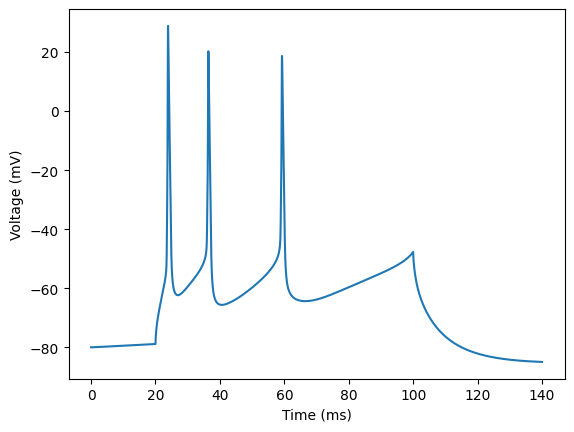

In [6]:
# set initial voltage
ng = NeuronGlobals.get_instance()
ng.v_init = -80


sim = Simulation()
sim.add_cell(cell)

# insert step current clamp of 1.25 nA 
cell.add_step(start_time=20.0, stop_time=100.0, level=1.5) 
sim.run(tstop=140, cvode=False)
time_single_h5_morphology, voltage_single_h5_morphology = cell.get_time(), cell.get_soma_voltage()
plt.plot(time_single_h5_morphology, voltage_single_h5_morphology)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")

### H5 Container Single Cell

We use the same hoc file but this time use a morphology stored in an H5 container.

In [7]:
hoc_file

'../../tests/examples/container_nbS1-O1__202247__cADpyr__L5_TPC_A/emodels_hoc/cADpyr_L5TPC.hoc'

We give the morphology path as `"merged-morphologies.h5/MorphName"` where `MorphName` is the name of the morphology in the H5 container. NB: `MorphName` does not have an extension at the end.


In [8]:
# Use H5 container format (correct way)
hoc_file = f"{data_folder}/emodels_hoc/cADpyr_L5TPC.hoc"
morph_h5_container = f"{data_folder}/morphologies/merged-morphologies.h5/dend-rat_20150119_LH1_cell1_axon-rp111203_C3_idA_-_Scale_x1.000_y0.950_z1.000_-_Clone_0"

print(f"HOC file:\n {hoc_file}")
print(f"Morphology container:\n {morph_h5_container}")

HOC file:
 ../../tests/examples/container_nbS1-O1__202247__cADpyr__L5_TPC_A/emodels_hoc/cADpyr_L5TPC.hoc
Morphology container:
 ../../tests/examples/container_nbS1-O1__202247__cADpyr__L5_TPC_A/morphologies/merged-morphologies.h5/dend-rat_20150119_LH1_cell1_axon-rp111203_C3_idA_-_Scale_x1.000_y0.950_z1.000_-_Clone_0


In [9]:
emodel_properties = EmodelProperties(threshold_current=threshold_current,
                                     holding_current=holding_current,
                                     AIS_scaler=1.0)
cell_container = Cell(template_path = hoc_file, 
            morphology_path = morph_h5_container, 
            template_format="v6", 
            emodel_properties=emodel_properties)

Text(0, 0.5, 'Voltage (mV)')

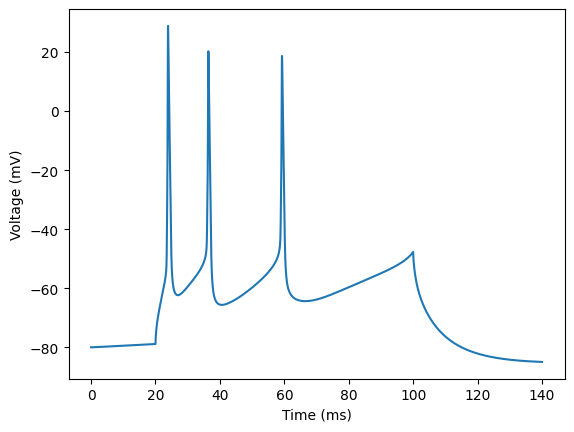

In [10]:
# set initial voltage
ng = NeuronGlobals.get_instance()
ng.v_init = -80


sim = Simulation()
sim.add_cell(cell)

# insert step current clamp of 1.25 nA 
cell_container.add_step(start_time=20.0, stop_time=100.0, level=1.5) 
sim.run(tstop=140, cvode=False)
time_container, voltage_container = cell_container.get_time(), cell_container.get_soma_voltage()
plt.plot(time_container, voltage_container)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")

### Compare the two results

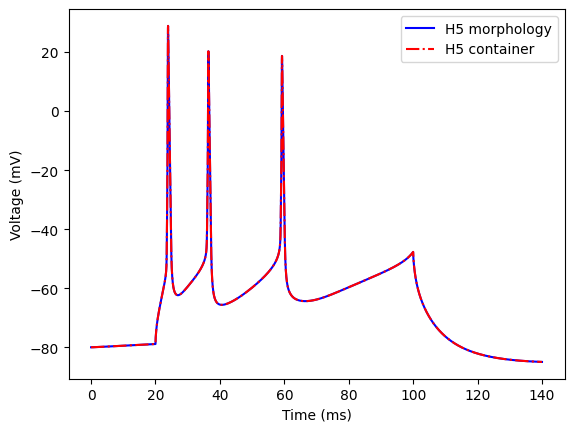

In [19]:
plt.plot(time_single_h5_morphology, voltage_single_h5_morphology, label="H5 morphology", color="blue", linestyle="-")
plt.plot(time_container, voltage_container, label="H5 container", color="red", linestyle="-.")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
plt.legend()
plt.show()

As you can see the results from cell initialization are the same for both H5 morphology and H5 container morphology.